In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Time Series Tasks

### Convert the longitudinal blood pressure measurements into a proper time series

In [47]:

df1 = pd.read_csv('patient_longitudinal.csv', sep='\t')

# Reliable parsing
df1['visit_date'] = pd.to_datetime(df1['visit_date'], format='%Y-%m-%d')

# Handle duplicates
df1 = df1.drop_duplicates(subset=['patient_id', 'visit_date'], keep='first')

# Set index
df1.set_index('visit_date', inplace=True)

#set timezone
df1.index = df1.index.tz_localize('America/Los_Angeles')

# Create the time series
ts = df1['bp_systolic']

# Handle missing values
ts = ts.interpolate(method='time').fillna(method='pad')

C:\Users\cbr98\AppData\Local\Temp\ipykernel_20640\551810801.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.interpolate(method='time').fillna(method='pad')


### Analyze blood pressure trends

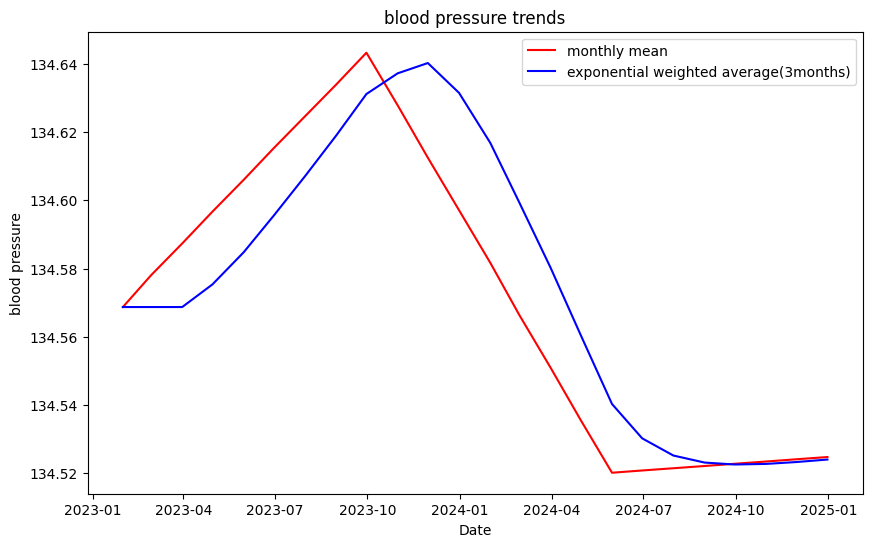

In [49]:
# Resample monthly
monthly_ts = ts.resample('ME').mean()
 
# 3month moving average
rolling_mean = monthly_ts.rolling(window=3, min_periods=1).mean()

#remove gap
rolling_mean = rolling_mean.interpolate()
monthly_ts = monthly_ts.interpolate()
#exponential weighted alternatives
ewm_mean = rolling_mean.ewm(span=3).mean()

#plot
plt.figure(figsize=(10, 6))
plt.title('blood pressure trends')
plt.xlabel('Date')
plt.ylabel('blood pressure')
plt.plot(monthly_ts,label = 'monthly mean', color = 'red')
plt.plot(ewm_mean,label = 'exponential weighted average(3months)', color = 'blue')
plt.legend()
plt.show()

## Statistical Modeling Tasks

### Analyze factors affecting baseline blood pressure


=== OLS Model Summary ===
                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     86.38
Date:                Wed, 06 Nov 2024   Prob (F-statistic):           4.45e-98
Time:                        10:03:19   Log-Likelihood:                -3698.9
No. Observations:                1000   AIC:                             7414.
Df Residuals:                     992   BIC:                             7453.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         109.4298 

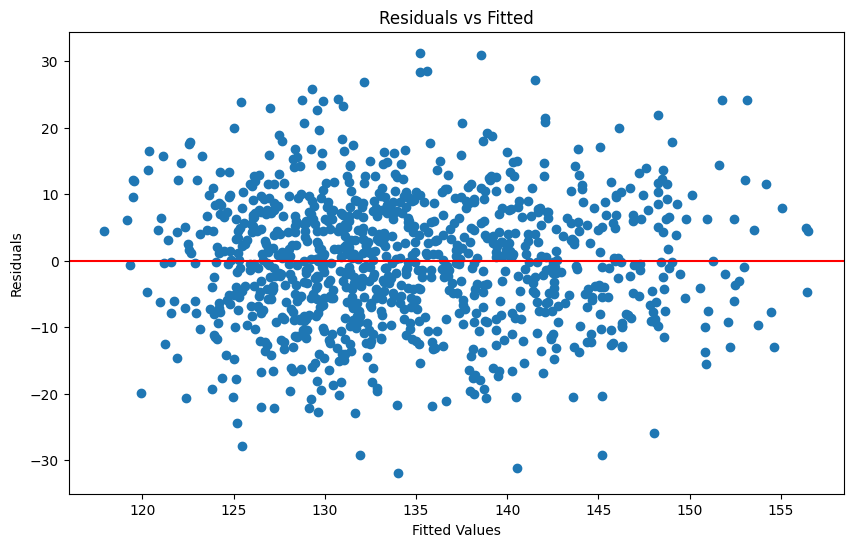


=== Q-Q Plot===


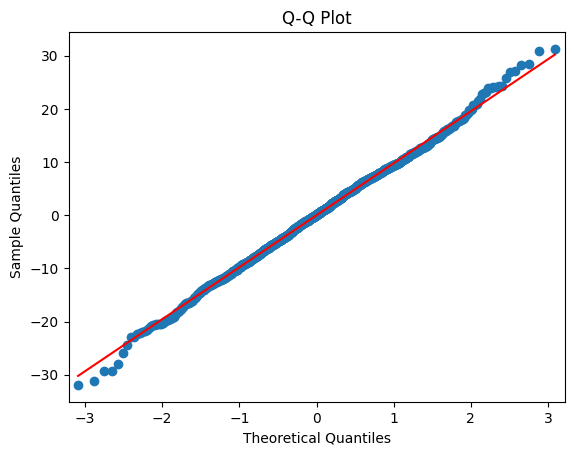

In [65]:
df2 = pd.read_csv('patient_baseline.csv', sep='\t')
# define x
predictors = ['age', 'sex', 'bmi', 'smoking', 'diabetes', 'cholesterol', 'heart_rate']
X = df2[predictors]
#define y
y = df2['bp_systolic']
# Add intercept column to X
X = sm.add_constant(X)

# OLS
model_result = sm.OLS(y, X).fit()

# print summary
print("\n=== OLS Model Summary ===")
print(model_result.summary())

#residuals vs fitted
fitted = model_result.fittedvalues
residual = model_result.resid
#plot scatter
plt.figure(figsize=(10, 6))
print("\n=== Residuals vs Fitted ===")
plt.scatter(fitted, residual)
plt.axhline(y=0, color='red')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Q-Q plot
print("\n=== Q-Q Plot===")
sm.qqplot(residual, line='s')
plt.title('Q-Q Plot')
plt.show()

### Model treatment effectiveness


=== odds ratios and CI===
             Odds Ratio        5%        95%
const          0.087170  0.012558   0.605095
age            1.006741  0.996580   1.017005
bmi            0.997229  0.969589   1.025656
sex            0.914620  0.704013   1.188232
smoking        0.835872  0.548230   1.274434
diabetes       0.679520  0.481731   0.958517
cholesterol    1.005908  0.999431   1.012427
heart_rate     0.990611  0.978432   1.002941
adherence      7.246128  1.945257  26.991991

=== residual deviance vs null deviance===
Residual Deviance: 1290.7501861819483
Null Deviance: 1334.774434101428


C:\Users\cbr98\AppData\Local\Temp\ipykernel_20640\1566480534.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


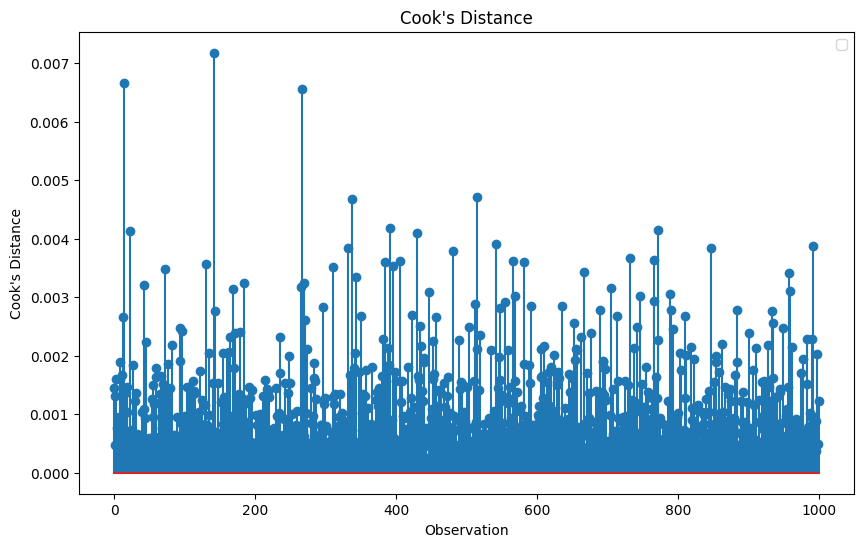

In [94]:
df3 = pd.read_csv('patient_treatment.csv', sep='\t')

#define X(basline characteristics and adherence) and y
predictors = ['age', 'bmi','sex', 'smoking', 'diabetes', 'cholesterol', 'heart_rate', 'adherence']
X = df3[predictors]
X = sm.add_constant(X)
y = df3['outcome']

# fit GLM model with binomial family
glm_model_result = sm.GLM(y, X, family=sm.families.Binomial()).fit()

# odds ratios and CI
odds = np.exp(glm_model_result.params)
CI = np.exp(glm_model_result.conf_int())
print("\n=== odds ratios and CI===")
print(pd.DataFrame({'Odds Ratio': odds, '5%': CI[0], '95%':CI[1]}))

# residual deviance vs null deviance
print("\n=== residual deviance vs null deviance===")
print("Residual Deviance:", glm_model_result.deviance)
print("Null Deviance:", glm_model_result.null_deviance)

# influential observations
influence = glm_model_result.get_influence()
summary = influence.summary_frame()
# cooked distance diagnostic plots
cooks = influence.cooks_distance[0]
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks)), cooks)
plt.title("Cook's Distance")
plt.xlabel("Observation")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

## Machine Learning Tasks

In [104]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (classification_report,RocCurveDisplay,confusion_matrix)

### Build a prediction pipeline

In [ ]:
#Create features from baseline characteristics
predictors = ['age', 'bmi','sex', 'smoking', 'diabetes', 'cholesterol', 'heart_rate', 'adherence']
X = df3[predictors]
y = df3['outcome'] 

#Standardize numeric feature
nume = ['age', 'bmi', 'cholesterol', 'heart_rate', 'adherence']
cate = ['smoking', 'diabetes','sex']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), nume),
        ('cat', OneHotEncoder(), cate)
    ]
)
# Create pipeline with specific components,regularization
pipeline = make_pipeline(
    preprocessor,                         
    SelectKBest(k='all'),               
    LogisticRegression(
        penalty='l2',                  
        solver='lbfgs',                
        max_iter=1000, 
        class_weight='balanced' 
    )
)


### Validate model performance


=== Report accuracy, precision, recall, and ROC AUC===
test_accuracy: 0.567
test_precision: 0.455
test_recall: 0.594
test_roc_auc: 0.605

=== confusion_matrix===
[[92 92]
 [49 67]]

===ROC curve===


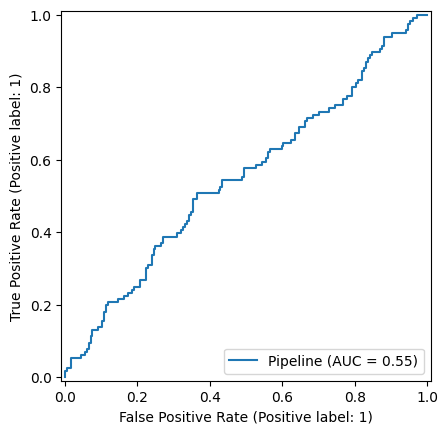

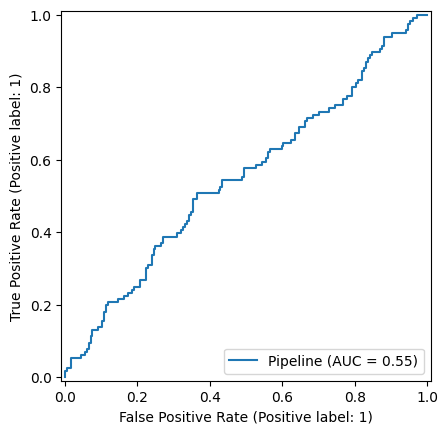

In [120]:
# Stratified split for imbalanced data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y,
    random_state=42
)

# 5 - fold Cross-validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc']
)

# Report accuracy, precision, recall, and ROC AUC
print("\n=== Report accuracy, precision, recall, and ROC AUC===")
for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_roc_auc']:
    print(f"{metric}: {scores[metric].mean():.3f}")

#train and evaluate
pipeline.fit(X_train, y_train)
y_pre = pipeline.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pre)
print("\n=== confusion_matrix===")
print(conf_matrix)

#Generate ROC curve
roc = RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
print("\n===ROC curve===")
roc.plot()